# Attention Maps for Neural Movement Classification
## Model Interpretability through Attention Mechanisms

**Authors:** Daniel Katz & Roi Wayner  
**Course:** Deep Learning for Physiological Signals (3360209)  
**Date:** 2025

---

## 📖 Notebook Overview

This notebook implements **attention mechanisms** for movement classification to provide model interpretability and identify which neurons contribute most to movement decoding decisions.

### Key Objectives:
1. **Implement attention-based CNN models** for interpretable classification
2. **Generate attention maps** showing neuron-level importance
3. **Identify key neurons** for different movement types
4. **Visualize attention patterns** across time and neural channels
5. **Compare attention weights** between different movements

### Attention Mechanisms:
- **Channel-wise attention**: Identifying important neurons
- **Temporal attention**: Finding critical time periods
- **Movement-specific patterns**: Attention differences across movement types
- **Cross-subject analysis**: Attention pattern generalization

### Applications:
- **Model interpretability**: Understanding "what the model sees"
- **Neuroscientific insights**: Identifying functionally important neurons
- **Feature selection**: Data-driven neuron selection for BMI applications
- **Validation**: Comparing with known motor cortex organization

---

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import wfdb

from tqdm import tqdm
# import torchviz

In [18]:
x =  np.load(r"dataset\Chip\train_500\X_long.npy")
y = np.load(r"dataset\Chip\train_500\y_long.npy")


x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")

x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

x = x[:,:,200:800]
x_val = x_val[:,:,200:800]
x_test = x_test[:,:,200:800]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')



X shape: (6000, 152, 600) y shape: (6000,)
X_val shape: (600, 152, 600) y_val shape: (600,)
X_test shape: (600, 152, 600) y_test shape: (600,)


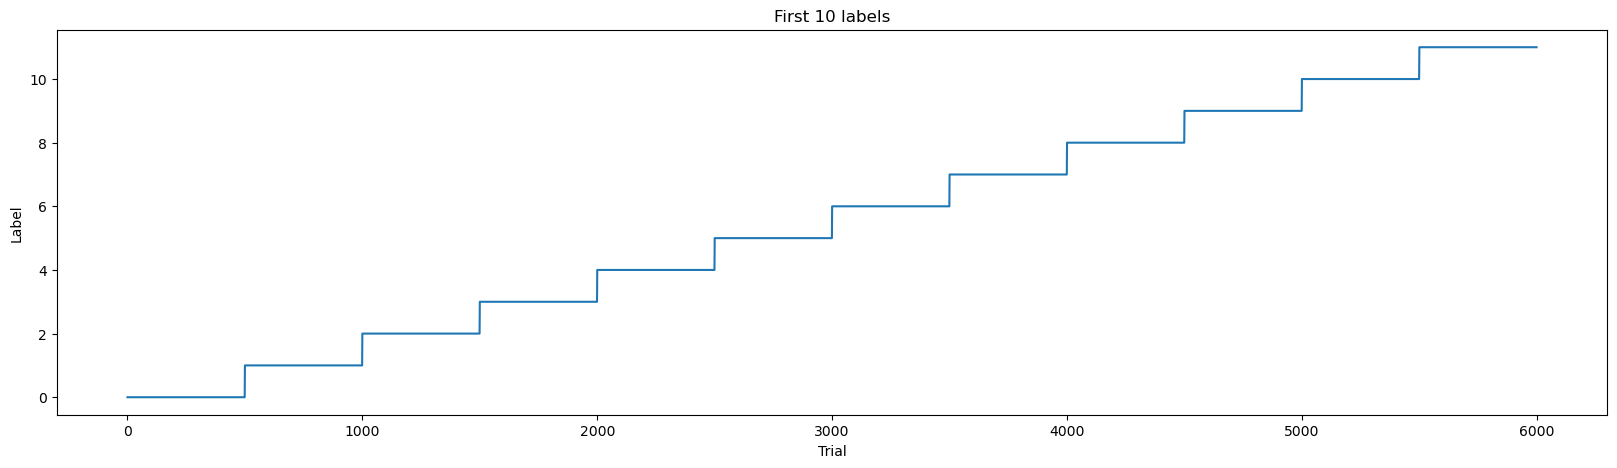

Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f


In [74]:
# plot the labels
plt.figure(figsize=(20, 5))
plt.plot(y[:])
plt.title('First 10 labels')
plt.xlabel('Trial')
plt.ylabel('Label')
plt.show()
print('Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f')

In [21]:
# transform the signal into a PyTorch tensor
class Ntransform(object):
    """
    This will transform the ECG signal into a PyTorch tensor. This is the place to apply other transformations as well, e.g., normalization, etc.
    """
    def __call__(self, signal):
        # Transform the data type from double (float64) to single (float32) to match the later network weights.
        t_signal = torch.from_numpy(signal).float()
        # We transpose the signal to later use the lead dim as the channel... (C,L).
        t_signal = t_signal.permute(1, 0)
        return t_signal  # Make sure I am a PyTorch Tensor

In [22]:
# Create a custom dataset class
class NeuronalDataset(Dataset):
    def __init__(self, signals_array, labels_array, transform=None):
        """
        Args:
            signals_array: np.ndarray, shape (N, T, C) -- neuronal activity
            labels_array: np.ndarray, shape (N,)        -- labels for samples
            transform: optional callable to transform signals
        """
        super().__init__()
        self.signals = signals_array
        self.labels = labels_array
        self.transform = transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]

        if self.transform:
            signal = self.transform(signal)

        signal = signal.detach().clone().float()
        label = torch.tensor(label, dtype=torch.long)  #classification

        return signal, label

    def __len__(self):
        return len(self.signals)

In [23]:
batch_size = 4
num_workers = 0

#train dataset
x = np.transpose(x, (0, 2, 1))
sampler = np.arange(x.shape[0])
train_sampler = SubsetRandomSampler(sampler)
train_dataset = NeuronalDataset(x, y, transform=Ntransform())
dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

#train validation dataset
x_val = np.transpose(x_val, (0, 2, 1))
sampler = np.arange(x_val.shape[0])
val_sampler = SubsetRandomSampler(sampler)
val_dataset = NeuronalDataset(x_val, y_val, transform=Ntransform())
dl_val = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

#test dataset
x_test = np.transpose(x_test, (0, 2, 1))
sampler = np.arange(x_test.shape[0])
test_sampler = SubsetRandomSampler(sampler)
test_dataset = NeuronalDataset(x_test, y_test, transform=Ntransform())
dl_test = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)




In [24]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
# Define a single Residual Block with 50% dropout after each convolution
class ResidualBlock(nn.Module):
    def __init__(self, in_channels , dropout=0.5):
        super().__init__()

        # Direct (main) path
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # Skip (shortcut) path
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# Now define a small network using several Residual Blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes , dropout=0.5):
        super().__init__()

        # Initial convolution (to go to a working channel size)
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.Dropout(dropout),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Stack of Residual Blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(16),
            ResidualBlock(16),
            ResidualBlock(16),
        )

        # Pooling and final classification layer
        self.pool = nn.AdaptiveAvgPool1d(1)  # Output: [batch, 16, 1]
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)  # shape [batch_size, 16]
        x = self.fc(x)
        return x


In [25]:
net = ResidualNet1D(152, num_classes=12, dropout=0)  # notice that we defined it in a way that the batch-size does not play a role, yet it needs to be included in the tensor shape.
print(net)

ResidualNet1D(
  (initial): Sequential(
    (0): Conv1d(152, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Dropout(p=0.5, inplace=False)
        (2): ReLU()
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): Dropout(p=0.5, inplace=False)
        (5): ReLU()
      )
      (skip_layers): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Dropout(p=0.5, inplace=False)
        (2): ReLU()
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): Dropout(p=0.5, inplace=Fals

In [26]:
# Define the model, loss function, and optimizer
loss_function = nn.CrossEntropyLoss()
# num param
print(sum(p.numel() for p in net.parameters()))

learning_rate = 0.0001

optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)


22796


In [27]:
def forward_epoch(model, dl, loss_function, optimizer, train_mode=True, desc=None, device=torch.device('cpu') , shuffle=False):
    total_loss = 0

    with tqdm(total=len(dl), desc=desc, ncols=100) as pbar:
        for i_batch, (X, y) in enumerate(dl):
            # if not train_mode and i_batch >= len(dl) // 3:
            #     break  # Process only half of the dataloader in evaluation mode
            
            if shuffle:
                # Randomly shuffle the channels on X
                X = X[:, torch.randperm(X.size(1)), :]
            X = X.to(device)
            y = y.to(device)

            # Forward:
            # print(f'X shape: {X.shape} y shape: {y.shape}')
            y_pred = model(X)  # [batch, num_classes]

            y_true = y.type(torch.float32)
            # print(f'y_pred.shape = {y_pred.shape}')
            # print(f'y_true = {y_true}')
            # print(f'y_true unique = {torch.unique(y_true)}')
            loss = loss_function(y_pred, y_true.long())

            total_loss += loss.item()

            if train_mode:  # Don't enter the gradient updating steps if not training.
                # Backward:
                optimizer.zero_grad()  # zero the gradients to not accumulate their changes.
                loss.backward()  # get gradients

                # Optimization step:
                optimizer.step()  # use gradients

            # Store y vectors over the epoch:
            if i_batch == 0:
                y_true_epoch = y_true
                y_pred_epoch = y_pred
            else:
                y_true_epoch = torch.concat((y_true_epoch, y_true))
                y_pred_epoch = torch.concat((y_pred_epoch, y_pred))

            # Progress bar:
            pbar.update(1)

    return total_loss, y_true_epoch, y_pred_epoch



In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , shuffled = False,  title = False):

    with torch.no_grad():
        train_set_loss, y_true_train, y_pred_train = forward_epoch(
            net, dl_train, loss_function, optimizer, train_mode=False, desc='Train', device=device , shuffle=shuffled)
        val_loss, y_true_val, y_pred_val = forward_epoch(
            net, dl_val, loss_function, optimizer, train_mode=False, desc='Val', device=device , shuffle=shuffled)
        test_loss, y_true_test, y_pred_test = forward_epoch(
            net, dl_test, loss_function, optimizer, train_mode=False, desc='Test', device=device , shuffle=shuffled)

    train_loss = train_set_loss / len(dl_train)
    train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
    val_loss = val_loss / len(dl_val)
    val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))
    test_loss = test_loss / len(dl_test)
    test_accuracy = accuracy_score(y_true_test.cpu(), y_pred_test.cpu().detach().argmax(dim=1))

    print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \n '
          f'Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)} \n'
          f'Test_loss={round(test_loss, 3)}; Test_accuracy={round(test_accuracy, 3)} \n')

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    if title:
        fig.suptitle(title, fontsize=17)
    else:
        fig.suptitle('Confusion Matrices', fontsize=17 )

    cm_train = confusion_matrix(y_true_train.cpu().numpy(), y_pred_train.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_title('Train' , fontsize=16 , y =1.16)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[0].text(0.0, 1.06, f'Overall Accuracy: {train_accuracy:.2f}', ha='left', va='center', transform=axs[0].transAxes)
    axs[0].text(0.0, 1.15, f'Overall Loss: {train_loss:.2f}', ha='left', va='center', transform=axs[0].transAxes)

    cm_val = confusion_matrix(y_true_val.cpu().numpy(), y_pred_val.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_title('Validation' , fontsize=16 , y =1.16)
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')
    axs[1].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[1].text(0.0, 1.06, f'Overall Accuracy: {val_accuracy:.2f}', ha='left', va='center', transform=axs[1].transAxes)
    axs[1].text(0.0, 1.15, f'Overall Loss: {val_loss:.2f}', ha='left', va='center', transform=axs[1].transAxes)

    cm_test = confusion_matrix(y_true_test.cpu().numpy(), y_pred_test.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[2])
    axs[2].set_title('Test' , fontsize=16 , y =1.16)
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    axs[2].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[2].text(0.0, 1.06, f'Overall Accuracy: {test_accuracy:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    axs[2].text(0.0, 1.15, f'Overall Loss: {test_loss:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()


# # test
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance')



In [83]:
%matplotlib inline

print("torch version: ", torch.__version__)
print("torch cuda: ", torch.cuda.is_available())
print("torch cuda version: ", torch.version.cuda)
print("torch cuda device count: ", torch.cuda.device_count())
print("torch cuda device name: ", torch.cuda.get_device_name())
print("torch cuda current device: ", torch.cuda.current_device())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clear cache
torch.cuda.empty_cache()

epochs = 50

train_loss_vec = []
val_loss_vec = []
train_accuracy_vec = []
val_accuracy_vec = []
best_val_loss = float('inf')
best_val_accuracy = 0
lr_vec = []

print(device)
net = net.to(device)  # Move the model to GPU if available

for i_epoch in range(epochs):
    print(f'Epoch: {i_epoch + 1}/{epochs}')

    net.train()  # model should be on train mode --> layers like Batch normalization and dropout will be affected.
    train_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer, train_mode=True,
                                                           desc='Train', device=device )
    if i_epoch % 1 == 0:
        net.eval()  # model should be on evaluation mode.
        # run train assessment to see how the model is doing.
        
        with torch.no_grad():  # Evaluation mode; thus, tell the model that we don't want gradients to be kept for updating (this will speed computation and save memory).
            print(f'epoch {i_epoch}')
            train_set_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer,
                                                                train_mode=False, desc='Train', device=device)
            val_loss, y_true_val, y_pred_val = forward_epoch(net, dl_val, loss_function, optimizer,
                                                                train_mode=False, desc='Val', device=device)

        # Metrics:
        train_loss = train_loss / len(dl_train)  # we want to get the mean over batches.
        train_loss_vec.append(train_loss)
        train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
        val_loss = val_loss / len(dl_val)
        val_loss_vec.append(val_loss)
        val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))

        train_accuracy_vec.append(train_accuracy)
        val_accuracy_vec.append(val_accuracy)

        print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \
            Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)}')
        
        # save checkpoint 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(), r'model_weights\model1_do\best_val_loss_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation loss: {val_loss:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(net.state_dict(), r'model_weights\model1_do\best_val_accuracy_cp.pth')
            print(f"Model saved at epoch {i_epoch + 1} with validation accuracy: {val_accuracy:.4f}")

    lr_vec.append(optimizer.param_groups[0]['lr'])
    lr_scheduler.step()  # update the learning rate according to the schedule.
# save the last checkpoint
torch.save(net.state_dict(), fr'model_weights\model1_do\last_cp_e{i_epoch+1}.pth')



torch version:  2.4.0+cu121
torch cuda:  True
torch cuda version:  12.1
torch cuda device count:  1
torch cuda device name:  NVIDIA GeForce RTX 4090
torch cuda current device:  0
cuda
Epoch: 1/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 257.16it/s]


epoch 0


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 637.46it/s]


Train_loss=2.151; Train_accuracy=0.572             Validation_loss=1.537; Validation_accuracy=0.517
Model saved at epoch 1 with validation loss: 1.5368
Model saved at epoch 1 with validation accuracy: 0.5167
Epoch: 2/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 280.72it/s]


epoch 1


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 360.55it/s]


Train_loss=1.256; Train_accuracy=0.764             Validation_loss=0.914; Validation_accuracy=0.583
Model saved at epoch 2 with validation loss: 0.9141
Model saved at epoch 2 with validation accuracy: 0.5833
Epoch: 3/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 141.15it/s]


epoch 2


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 335.54it/s]


Train_loss=0.843; Train_accuracy=0.993             Validation_loss=0.528; Validation_accuracy=0.888
Model saved at epoch 3 with validation loss: 0.5283
Model saved at epoch 3 with validation accuracy: 0.8883
Epoch: 4/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 141.90it/s]


epoch 3


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 322.90it/s]


Train_loss=0.619; Train_accuracy=0.998             Validation_loss=0.371; Validation_accuracy=0.973
Model saved at epoch 4 with validation loss: 0.3709
Model saved at epoch 4 with validation accuracy: 0.9733
Epoch: 5/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 141.18it/s]


epoch 4


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 327.48it/s]


Train_loss=0.442; Train_accuracy=0.999             Validation_loss=0.222; Validation_accuracy=0.98
Model saved at epoch 5 with validation loss: 0.2216
Model saved at epoch 5 with validation accuracy: 0.9800
Epoch: 6/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 138.89it/s]


epoch 5


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 578.32it/s]


Train_loss=0.331; Train_accuracy=1.0             Validation_loss=0.222; Validation_accuracy=0.963
Epoch: 7/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 276.80it/s]


epoch 6


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 626.22it/s]


Train_loss=0.263; Train_accuracy=1.0             Validation_loss=0.094; Validation_accuracy=0.998
Model saved at epoch 7 with validation loss: 0.0945
Model saved at epoch 7 with validation accuracy: 0.9983
Epoch: 8/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 285.60it/s]


epoch 7


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 630.11it/s]


Train_loss=0.182; Train_accuracy=1.0             Validation_loss=0.104; Validation_accuracy=0.997
Epoch: 9/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 265.37it/s]


epoch 8


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 638.02it/s]


Train_loss=0.14; Train_accuracy=0.99             Validation_loss=0.151; Validation_accuracy=0.95
Epoch: 10/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 277.20it/s]


epoch 9


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 598.00it/s]


Train_loss=0.095; Train_accuracy=1.0             Validation_loss=0.144; Validation_accuracy=0.915
Epoch: 11/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 275.56it/s]


epoch 10


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 635.53it/s]


Train_loss=0.073; Train_accuracy=1.0             Validation_loss=0.022; Validation_accuracy=1.0
Model saved at epoch 11 with validation loss: 0.0219
Model saved at epoch 11 with validation accuracy: 1.0000
Epoch: 12/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 267.91it/s]


epoch 11


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 599.85it/s]


Train_loss=0.058; Train_accuracy=1.0             Validation_loss=0.154; Validation_accuracy=0.913
Epoch: 13/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 272.46it/s]


epoch 12


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 624.87it/s]


Train_loss=0.044; Train_accuracy=1.0             Validation_loss=0.166; Validation_accuracy=0.91
Epoch: 14/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 282.25it/s]


epoch 13


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 616.08it/s]


Train_loss=0.032; Train_accuracy=1.0             Validation_loss=0.041; Validation_accuracy=1.0
Epoch: 15/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 292.76it/s]


epoch 14


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 607.03it/s]


Train_loss=0.031; Train_accuracy=0.999             Validation_loss=0.175; Validation_accuracy=0.915
Epoch: 16/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 285.93it/s]


epoch 15


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 600.90it/s]


Train_loss=0.028; Train_accuracy=1.0             Validation_loss=0.042; Validation_accuracy=0.998
Epoch: 17/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 280.65it/s]


epoch 16


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 632.80it/s]


Train_loss=0.018; Train_accuracy=1.0             Validation_loss=0.053; Validation_accuracy=0.995
Epoch: 18/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 279.56it/s]


epoch 17


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 621.01it/s]


Train_loss=0.018; Train_accuracy=1.0             Validation_loss=0.173; Validation_accuracy=0.895
Epoch: 19/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 266.24it/s]


epoch 18


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 622.34it/s]


Train_loss=0.016; Train_accuracy=1.0             Validation_loss=0.07; Validation_accuracy=0.983
Epoch: 20/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 273.78it/s]


epoch 19


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 601.07it/s]


Train_loss=0.015; Train_accuracy=1.0             Validation_loss=0.175; Validation_accuracy=0.905
Epoch: 21/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 273.45it/s]


epoch 20


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 614.95it/s]


Train_loss=0.011; Train_accuracy=1.0             Validation_loss=0.065; Validation_accuracy=0.973
Epoch: 22/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 278.88it/s]


epoch 21


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 597.57it/s]


Train_loss=0.01; Train_accuracy=1.0             Validation_loss=0.073; Validation_accuracy=0.955
Epoch: 23/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 236.03it/s]


epoch 22


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 628.81it/s]


Train_loss=0.01; Train_accuracy=1.0             Validation_loss=0.248; Validation_accuracy=0.867
Epoch: 24/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 280.24it/s]


epoch 23


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 602.37it/s]


Train_loss=0.01; Train_accuracy=1.0             Validation_loss=0.098; Validation_accuracy=0.922
Epoch: 25/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 265.88it/s]


epoch 24


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 591.61it/s]


Train_loss=0.009; Train_accuracy=1.0             Validation_loss=0.182; Validation_accuracy=0.917
Epoch: 26/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 260.20it/s]


epoch 25


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 579.57it/s]


Train_loss=0.011; Train_accuracy=1.0             Validation_loss=0.093; Validation_accuracy=0.97
Epoch: 27/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 255.19it/s]


epoch 26


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 581.35it/s]


Train_loss=0.006; Train_accuracy=1.0             Validation_loss=0.096; Validation_accuracy=0.932
Epoch: 28/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 261.12it/s]


epoch 27


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 588.18it/s]


Train_loss=0.007; Train_accuracy=1.0             Validation_loss=0.132; Validation_accuracy=0.91
Epoch: 29/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 263.72it/s]


epoch 28


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 591.62it/s]


Train_loss=0.005; Train_accuracy=1.0             Validation_loss=0.21; Validation_accuracy=0.893
Epoch: 30/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 265.89it/s]


epoch 29


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 605.11it/s]


Train_loss=0.005; Train_accuracy=1.0             Validation_loss=0.334; Validation_accuracy=0.847
Epoch: 31/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 257.45it/s]


epoch 30


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 598.41it/s]


Train_loss=0.006; Train_accuracy=1.0             Validation_loss=0.08; Validation_accuracy=0.945
Epoch: 32/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 260.50it/s]


epoch 31


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 562.92it/s]


Train_loss=0.007; Train_accuracy=1.0             Validation_loss=0.017; Validation_accuracy=1.0
Model saved at epoch 32 with validation loss: 0.0165
Epoch: 33/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 263.40it/s]


epoch 32


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 615.91it/s]


Train_loss=0.005; Train_accuracy=1.0             Validation_loss=0.064; Validation_accuracy=0.982
Epoch: 34/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 258.74it/s]


epoch 33


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 602.35it/s]


Train_loss=0.007; Train_accuracy=1.0             Validation_loss=0.103; Validation_accuracy=0.955
Epoch: 35/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 264.05it/s]


epoch 34


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 594.73it/s]


Train_loss=0.001; Train_accuracy=1.0             Validation_loss=0.052; Validation_accuracy=0.985
Epoch: 36/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 262.90it/s]


epoch 35


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 607.18it/s]


Train_loss=0.002; Train_accuracy=1.0             Validation_loss=0.059; Validation_accuracy=0.978
Epoch: 37/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 265.89it/s]


epoch 36


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 568.12it/s]


Train_loss=0.007; Train_accuracy=1.0             Validation_loss=0.342; Validation_accuracy=0.842
Epoch: 38/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 268.24it/s]


epoch 37


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 608.01it/s]


Train_loss=0.001; Train_accuracy=1.0             Validation_loss=0.254; Validation_accuracy=0.918
Epoch: 39/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 266.49it/s]


epoch 38


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 624.41it/s]


Train_loss=0.003; Train_accuracy=1.0             Validation_loss=0.138; Validation_accuracy=0.942
Epoch: 40/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 248.49it/s]


epoch 39


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 614.12it/s]


Train_loss=0.001; Train_accuracy=1.0             Validation_loss=0.19; Validation_accuracy=0.925
Epoch: 41/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 249.97it/s]


epoch 40


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 589.25it/s]


Train_loss=0.003; Train_accuracy=1.0             Validation_loss=0.014; Validation_accuracy=1.0
Model saved at epoch 41 with validation loss: 0.0138
Epoch: 42/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 256.75it/s]


epoch 41


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 562.68it/s]


Train_loss=0.005; Train_accuracy=1.0             Validation_loss=0.056; Validation_accuracy=0.982
Epoch: 43/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 268.89it/s]


epoch 42


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 582.42it/s]


Train_loss=0.003; Train_accuracy=1.0             Validation_loss=0.164; Validation_accuracy=0.922
Epoch: 44/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 265.99it/s]


epoch 43


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 646.18it/s]


Train_loss=0.0; Train_accuracy=1.0             Validation_loss=0.087; Validation_accuracy=0.937
Epoch: 45/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 270.35it/s]


epoch 44


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 630.19it/s]


Train_loss=0.001; Train_accuracy=1.0             Validation_loss=0.19; Validation_accuracy=0.93
Epoch: 46/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 268.50it/s]


epoch 45


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 552.37it/s]


Train_loss=0.005; Train_accuracy=1.0             Validation_loss=0.047; Validation_accuracy=0.987
Epoch: 47/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 269.79it/s]


epoch 46


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 612.13it/s]


Train_loss=0.004; Train_accuracy=1.0             Validation_loss=0.036; Validation_accuracy=0.985
Epoch: 48/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 273.38it/s]


epoch 47


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 598.72it/s]


Train_loss=0.003; Train_accuracy=1.0             Validation_loss=0.161; Validation_accuracy=0.935
Epoch: 49/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 272.97it/s]


epoch 48


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 627.54it/s]


Train_loss=0.002; Train_accuracy=1.0             Validation_loss=0.053; Validation_accuracy=0.978
Epoch: 50/50


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 270.22it/s]


epoch 49


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 628.36it/s]

Train_loss=0.004; Train_accuracy=1.0             Validation_loss=0.054; Validation_accuracy=0.978


# PLOT TRAINING AND EVALUATION

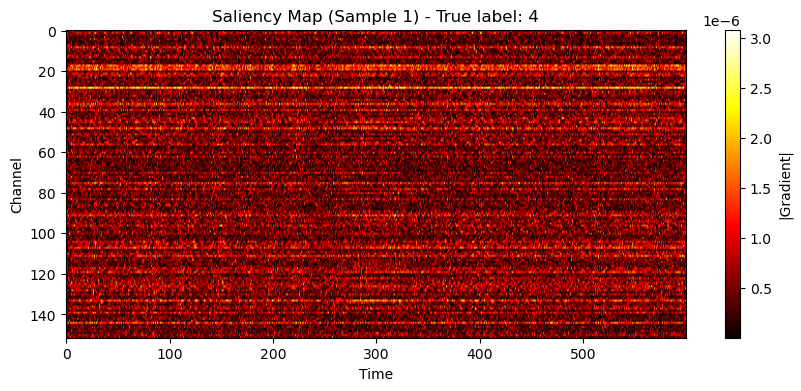

Sample 1 - True label: 4
Top 10 most important channels (by mean gradient): [ 28  17  19 133  48 144  18  36 107   8]


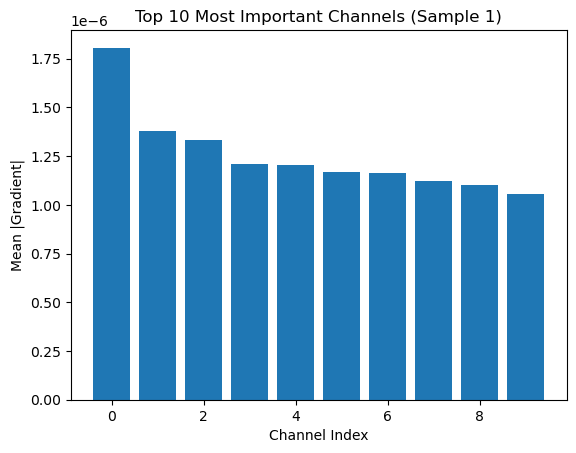

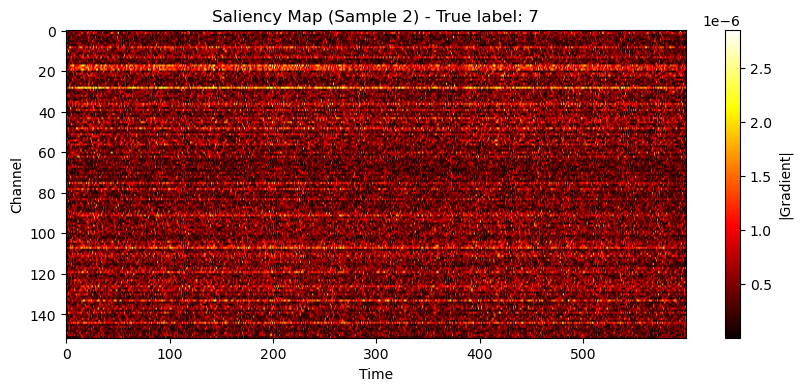

Sample 2 - True label: 7
Top 10 most important channels (by mean gradient): [ 28  17 107  19 133 144  18  48   8  36]


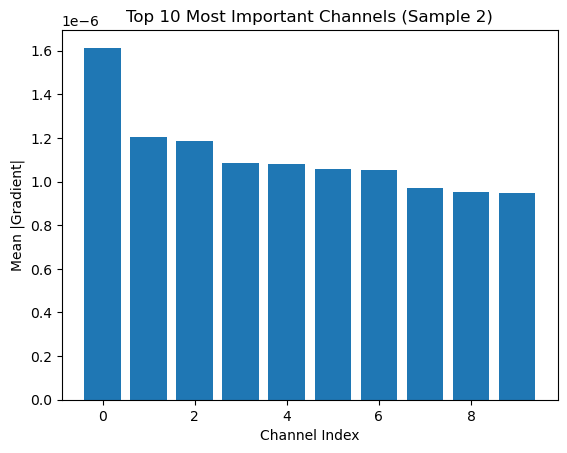

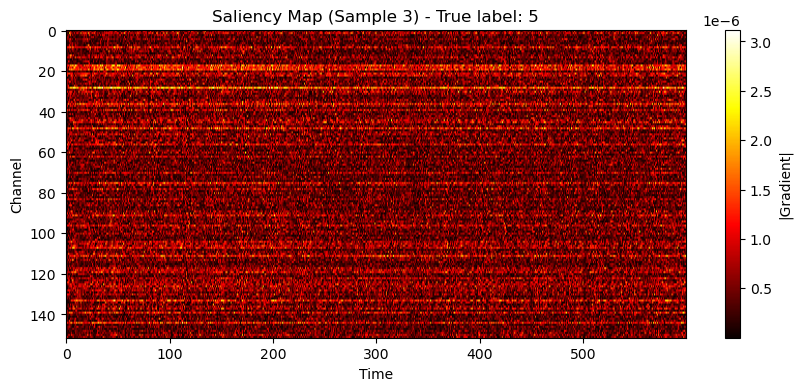

Sample 3 - True label: 5
Top 10 most important channels (by mean gradient): [ 28  17  19  48  36 133 111 144  18  75]


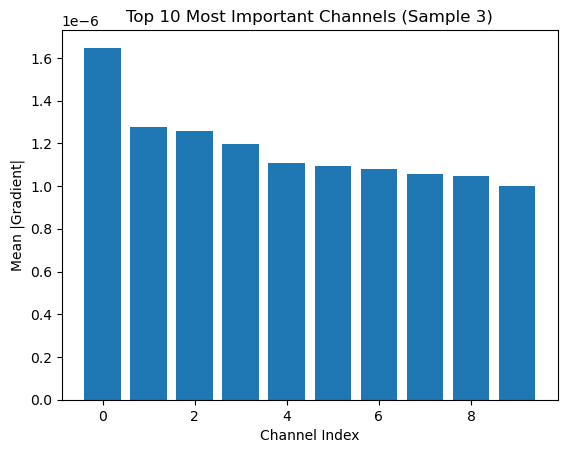

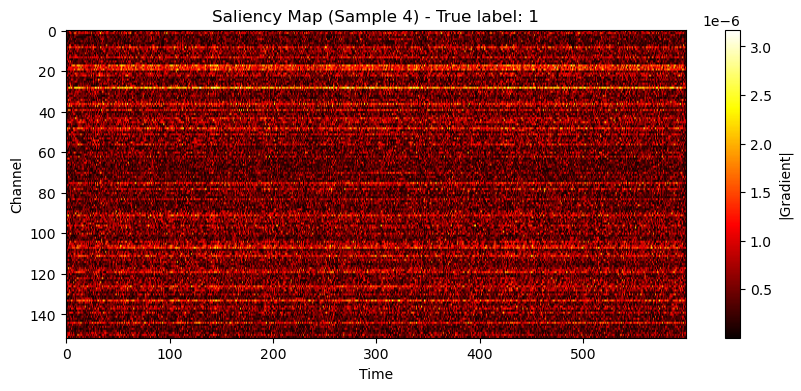

Sample 4 - True label: 1
Top 10 most important channels (by mean gradient): [ 28  17  19 133 107  48  18  36 144 111]


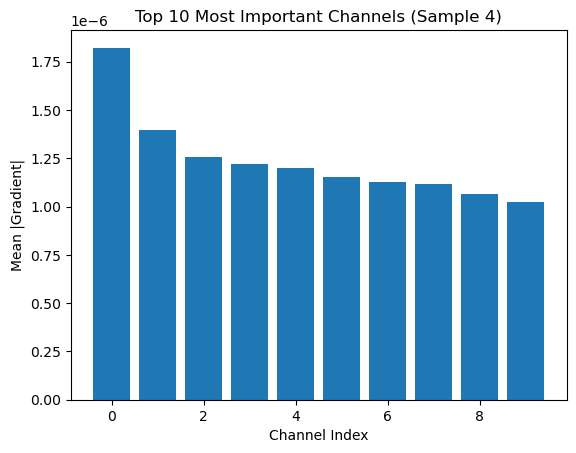

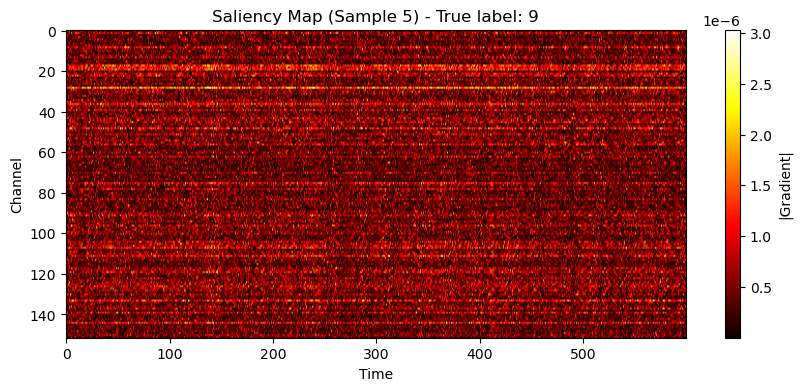

Sample 5 - True label: 9
Top 10 most important channels (by mean gradient): [ 28  17  19  36 133  48  18 144 111 107]


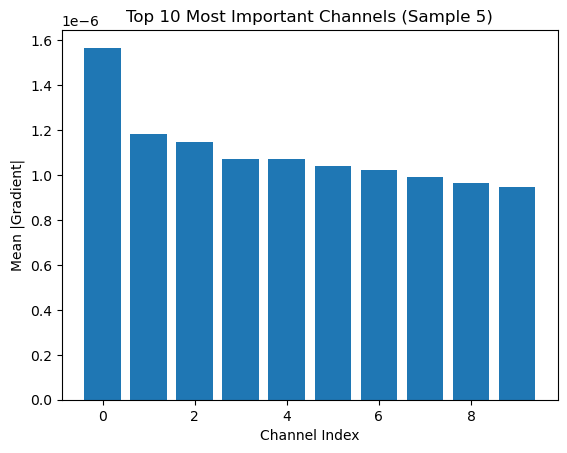

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get 5 random indices from the test set
num_examples = 5
dl_iter = iter(dl_test)
X_all, y_all = next(dl_iter)
for _ in range(1, len(dl_test)):
    X_batch, y_batch = next(dl_iter)
    X_all = torch.cat([X_all, X_batch], dim=0)
    y_all = torch.cat([y_all, y_batch], dim=0)

indices = np.random.choice(X_all.shape[0], num_examples, replace=False)
X_samples = X_all[indices].to(device)
y_samples = y_all[indices].cpu().numpy()

X_samples.requires_grad = True

net.eval()
output = net(X_samples)
pred = output.argmax(dim=1)

loss = loss_function(output, pred)
loss.backward(torch.ones_like(loss))

grads = X_samples.grad.detach().cpu().numpy()  # [batch, channels, time]

for i in range(num_examples):
    mean_grad = np.abs(grads[i])
    plt.figure(figsize=(10, 4))
    plt.imshow(mean_grad, aspect='auto', cmap='hot')
    plt.colorbar(label='|Gradient|')
    plt.xlabel('Time')
    plt.ylabel('Channel')
    plt.title(f'Saliency Map (Sample {i+1}) - True label: {y_samples[i]}')
    plt.show()

    channel_importance = mean_grad.mean(axis=1)
    top_channels = np.argsort(channel_importance)[::-1][:10]
    print(f"Sample {i+1} - True label: {y_samples[i]}")
    print("Top 10 most important channels (by mean gradient):", top_channels)
    plt.figure()
    plt.bar(range(len(top_channels)), channel_importance[top_channels])
    plt.xlabel('Channel Index')
    plt.ylabel('Mean |Gradient|')
    plt.title(f'Top 10 Most Important Channels (Sample {i+1})')
    plt.show()

In [35]:
channels = ["C0027", "C0033", "C0039", "C0046", "C0048", "C0066", "C0072", "C0084", "C0086", "C0088", "C0090", "C0096", "C0098", "C0100", "C0102", "C0106", "C0107", "C0111", "C0113", "C0115", "C0116", "C0120", "C0121", "C0125", "C0129", "C0130", "C0131", "C0136", "C0137", "C0139", "C0149", "C0155", "C0161", "C0168", "C0176", "C0177", "C0182", "C0185", "C0200", "C0216", "C0221", "C0223", "C0224", "C0226", "C0227", "C0231", "C0232", "C0233", "C0235", "C0236", "C0237", "C0238", "C0242", "C0253", "C0254", "C0255", "C0257", "C0258", "C0259", "C0260", "C0262", "C0269", "C0285", "C0295", "C0299", "C0305", "C0308", "C0309", "C0310", "C0311", "C0314", "C0316", "C0319", "C0324", "C0325", "C0329", "C0330", "C0334", "C0336", "C0339", "C0340", "C0342", "C0343", "C0346", "C0350", "C0351", "C0352", "C0353", "C0365", "C0374", "C0375", "C0376", "C0393", "C0397", "C0398", "C0403", "C0415", "C0427", "C0428", "C0429", "C0430", "C0434", "C0438", "C0440", "C0443", "C0444", "C0445", "C0448", "C0449", "C0450", "C0451", "C0455", "C0456", "C0457", "C0458", "c0114", "c0211", "c0315", "c0460", "c0461", "c0462", "c0463", "c0472", "c0473", "c0474", "c0475", "c0476", "c0478", "c0479", "c0480", "c0484", "c0486", "c0490", "c0491", "c0492", "c0499", "c0502", "c0503", "c0504", "c0505", "c0506", "c0507", "c0509", "c0517", "c0521", "c0523", "c0524", "c0526", "c0531", "c0538", "c0542", "c0545"]
# Get the channel names for the top 5 most important channels
top5_indices = [28, 17, 19, 133, 48]
top5_channel_names = [channels[i] for i in top5_indices]
print("Top 5 most important channels:", top5_channel_names)

Top 5 most important channels: ['C0137', 'C0111', 'C0115', 'c0491', 'C0235']
